Loads the Wine Quality dataset (178 samples, 13 features, 3 wine classes)


In [2]:
# Block 1: Import Libraries and Load Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Load Wine dataset
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Series(wine.target, name='wine_class')

print("Dataset Shape:", X.shape)
print("\nFeatures:", list(X.columns))
print("\nFirst few rows:")
print(X.head())
print("\nTarget distribution:")
print(y.value_counts())



Dataset Shape: (178, 13)

Features: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']

First few rows:
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30  

Visualizes the dataset with correlation heatmap, class distribution, feature importance, and value ranges

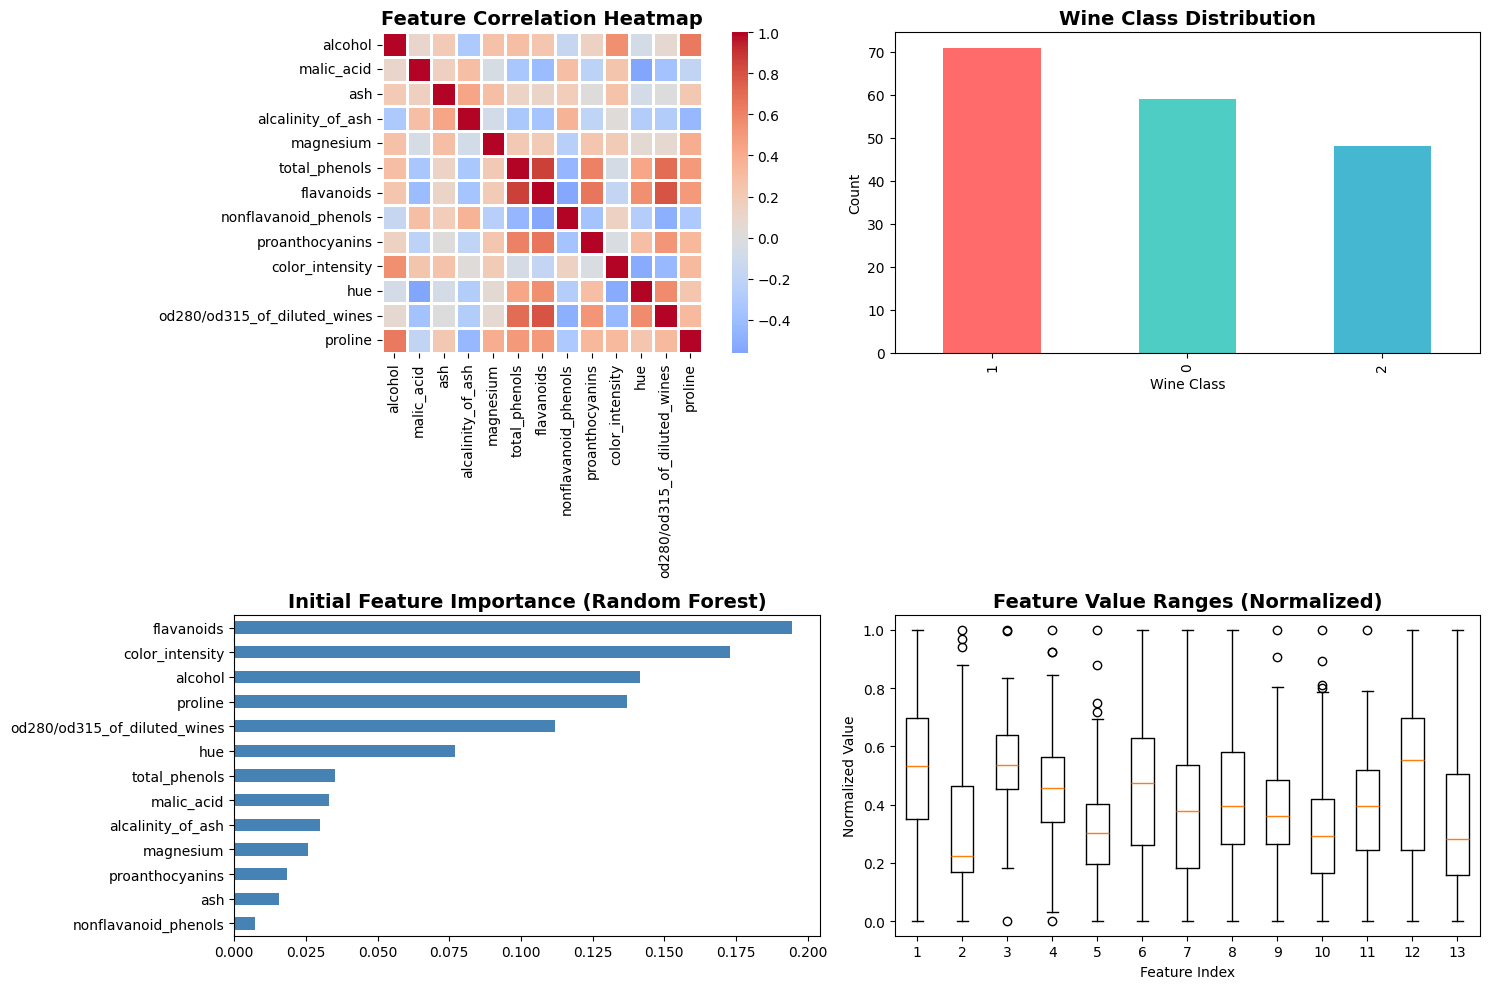

In [3]:
# Block 2: Data Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Feature correlation heatmap
axes[0, 0].set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
sns.heatmap(X.corr(), ax=axes[0, 0], cmap='coolwarm', center=0, square=True, linewidths=1)

# Target distribution
axes[0, 1].set_title('Wine Class Distribution', fontsize=14, fontweight='bold')
y.value_counts().plot(kind='bar', ax=axes[0, 1], color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
axes[0, 1].set_xlabel('Wine Class')
axes[0, 1].set_ylabel('Count')

# Feature importance using Random Forest
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X, y)
feature_imp = pd.Series(rf_temp.feature_importances_, index=X.columns).sort_values(ascending=False)
axes[1, 0].set_title('Initial Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
feature_imp.plot(kind='barh', ax=axes[1, 0], color='steelblue')
axes[1, 0].invert_yaxis()

# Box plot for feature distributions
axes[1, 1].set_title('Feature Value Ranges (Normalized)', fontsize=14, fontweight='bold')
X_normalized = (X - X.min()) / (X.max() - X.min())
axes[1, 1].boxplot(X_normalized.values, labels=range(1, len(X.columns)+1))
axes[1, 1].set_xlabel('Feature Index')
axes[1, 1].set_ylabel('Normalized Value')

plt.tight_layout()
plt.show()



Implements the complete ACO algorithm with:

- Pheromone initialization and updates
- Heuristic calculation using Random Forest
- Ant solution generation based on probabilities
- Fitness evaluation with feature penalty

In [4]:
# Block 3: Ant Colony Optimization Class
class AntColonyOptimization:
    def __init__(self, n_ants=20, n_iterations=50, decay=0.5, alpha=1, beta=2):
        """
        ACO for feature selection
        n_ants: number of ants
        n_iterations: number of iterations
        decay: pheromone decay rate
        alpha: pheromone importance
        beta: heuristic importance
        """
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.best_solution = None
        self.best_fitness = 0
        self.history = []
        
    def initialize_pheromones(self, n_features):
        """Initialize pheromone matrix"""
        return np.ones(n_features)
    
    def calculate_heuristic(self, X, y):
        """Calculate heuristic information (feature importance)"""
        rf = RandomForestClassifier(n_estimators=50, random_state=42)
        rf.fit(X, y)
        return rf.feature_importances_
    
    def ant_solution(self, pheromones, heuristic, n_features):
        """Generate solution for one ant"""
        probabilities = (pheromones ** self.alpha) * (heuristic ** self.beta)
        probabilities = probabilities / probabilities.sum()
        
        # Select features based on probabilities
        n_select = max(3, int(n_features * 0.5))  # Select at least 3 features
        selected = np.random.choice(n_features, size=n_select, replace=False, p=probabilities)
        
        solution = np.zeros(n_features, dtype=bool)
        solution[selected] = True
        return solution
    
    def evaluate_fitness(self, solution, X, y):
        """Evaluate fitness of solution using cross-validation"""
        if solution.sum() == 0:
            return 0
        
        X_selected = X[:, solution]
        X_train, X_test, y_train, y_test = train_test_split(
            X_selected, y, test_size=0.3, random_state=42, stratify=y
        )
        
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_test, y_test)
        
        # Penalize for using too many features
        feature_penalty = solution.sum() / len(solution) * 0.1
        fitness = accuracy - feature_penalty
        
        return fitness
    
    def update_pheromones(self, pheromones, all_solutions, all_fitness):
        """Update pheromone levels"""
        # Decay
        pheromones *= (1 - self.decay)
        
        # Add new pheromones
        for solution, fitness in zip(all_solutions, all_fitness):
            pheromones[solution] += fitness
        
        return pheromones
    
    def fit(self, X, y):
        """Run ACO algorithm"""
        n_features = X.shape[1]
        pheromones = self.initialize_pheromones(n_features)
        heuristic = self.calculate_heuristic(X, y)
        
        for iteration in range(self.n_iterations):
            all_solutions = []
            all_fitness = []
            
            # Generate solutions for all ants
            for ant in range(self.n_ants):
                solution = self.ant_solution(pheromones, heuristic, n_features)
                fitness = self.evaluate_fitness(solution, X, y)
                
                all_solutions.append(solution)
                all_fitness.append(fitness)
                
                # Update best solution
                if fitness > self.best_fitness:
                    self.best_fitness = fitness
                    self.best_solution = solution.copy()
            
            # Update pheromones
            pheromones = self.update_pheromones(pheromones, all_solutions, all_fitness)
            
            # Store history
            self.history.append({
                'iteration': iteration,
                'best_fitness': self.best_fitness,
                'avg_fitness': np.mean(all_fitness),
                'pheromones': pheromones.copy(),
                'n_features_selected': self.best_solution.sum()
            })
            
            if (iteration + 1) % 10 == 0:
                print(f"Iteration {iteration + 1}/{self.n_iterations} - "
                      f"Best Fitness: {self.best_fitness:.4f} - "
                      f"Features Selected: {self.best_solution.sum()}")
        
        return self



Runs the ACO optimization for 50 iterations with 20 ants

In [5]:
# Block 4: Prepare Data and Run ACO
# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Run ACO
print("Running Ant Colony Optimization for Feature Selection...\n")
aco = AntColonyOptimization(n_ants=20, n_iterations=50, decay=0.5, alpha=1, beta=2)
aco.fit(X_train_scaled, y_train)

print("\n" + "="*60)
print("ACO Optimization Complete!")
print("="*60)
print(f"Best Fitness Score: {aco.best_fitness:.4f}")
print(f"Features Selected: {aco.best_solution.sum()} out of {len(X.columns)}")
print("\nSelected Features:")
selected_features = X.columns[aco.best_solution].tolist()
for i, feat in enumerate(selected_features, 1):
    print(f"  {i}. {feat}")



Running Ant Colony Optimization for Feature Selection...

Iteration 10/50 - Best Fitness: 0.9012 - Features Selected: 6
Iteration 20/50 - Best Fitness: 0.9012 - Features Selected: 6
Iteration 30/50 - Best Fitness: 0.9012 - Features Selected: 6
Iteration 40/50 - Best Fitness: 0.9012 - Features Selected: 6
Iteration 50/50 - Best Fitness: 0.9012 - Features Selected: 6

ACO Optimization Complete!
Best Fitness Score: 0.9012
Features Selected: 6 out of 13

Selected Features:
  1. alcohol
  2. flavanoids
  3. color_intensity
  4. hue
  5. od280/od315_of_diluted_wines
  6. proline


Visualizes ACO progress with 4 plots:

- Fitness evolution (best & average)
- Number of features selected over time
- Final pheromone levels
- Pheromone evolution heatmap

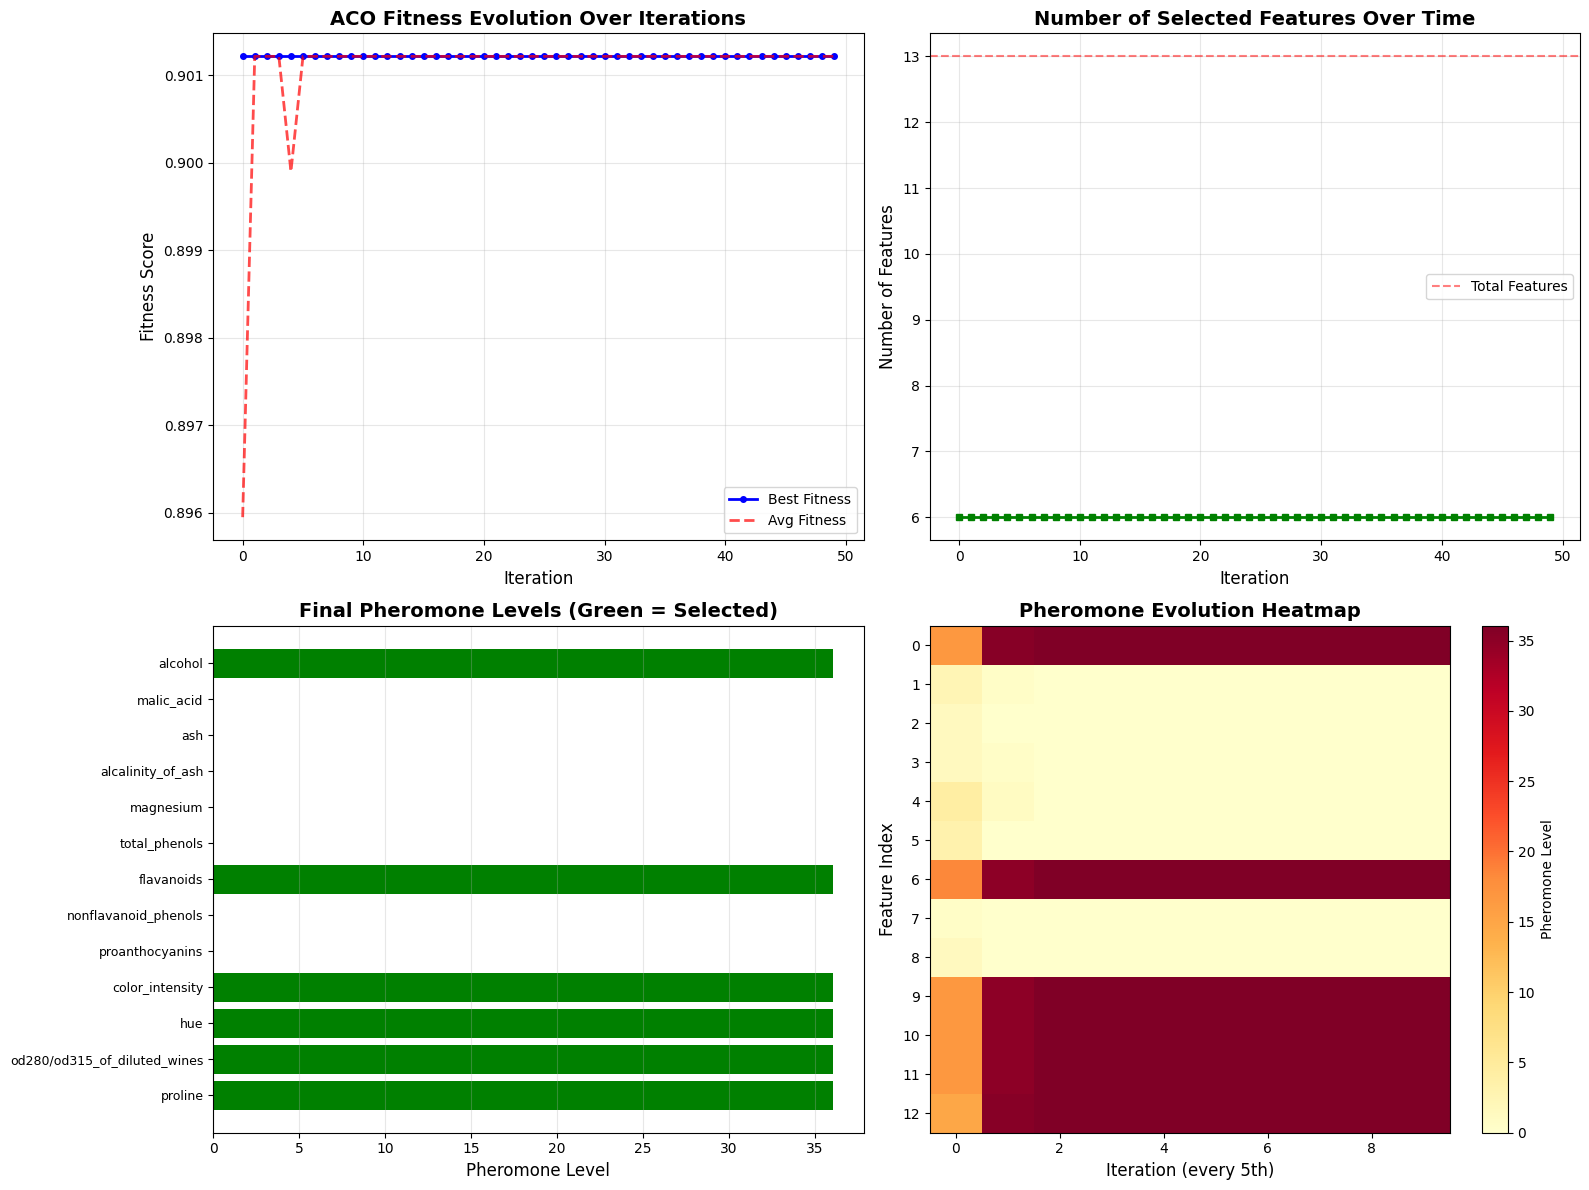

In [6]:
# Block 5: Visualize ACO Progress
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Fitness evolution
history_df = pd.DataFrame(aco.history)
axes[0, 0].plot(history_df['iteration'], history_df['best_fitness'], 
                'b-', linewidth=2, label='Best Fitness', marker='o', markersize=4)
axes[0, 0].plot(history_df['iteration'], history_df['avg_fitness'], 
                'r--', linewidth=2, label='Avg Fitness', alpha=0.7)
axes[0, 0].set_xlabel('Iteration', fontsize=12)
axes[0, 0].set_ylabel('Fitness Score', fontsize=12)
axes[0, 0].set_title('ACO Fitness Evolution Over Iterations', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Number of features selected
axes[0, 1].plot(history_df['iteration'], history_df['n_features_selected'], 
                'g-', linewidth=2, marker='s', markersize=4)
axes[0, 1].axhline(y=len(X.columns), color='r', linestyle='--', label='Total Features', alpha=0.5)
axes[0, 1].set_xlabel('Iteration', fontsize=12)
axes[0, 1].set_ylabel('Number of Features', fontsize=12)
axes[0, 1].set_title('Number of Selected Features Over Time', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Final pheromone levels
final_pheromones = aco.history[-1]['pheromones']
colors = ['green' if aco.best_solution[i] else 'lightcoral' for i in range(len(X.columns))]
axes[1, 0].barh(range(len(X.columns)), final_pheromones, color=colors)
axes[1, 0].set_yticks(range(len(X.columns)))
axes[1, 0].set_yticklabels(X.columns, fontsize=9)
axes[1, 0].set_xlabel('Pheromone Level', fontsize=12)
axes[1, 0].set_title('Final Pheromone Levels (Green = Selected)', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Pheromone heatmap over time
pheromone_matrix = np.array([h['pheromones'] for h in aco.history[::5]])  # Every 5th iteration
im = axes[1, 1].imshow(pheromone_matrix.T, aspect='auto', cmap='YlOrRd', interpolation='nearest')
axes[1, 1].set_xlabel('Iteration (every 5th)', fontsize=12)
axes[1, 1].set_ylabel('Feature Index', fontsize=12)
axes[1, 1].set_title('Pheromone Evolution Heatmap', fontsize=14, fontweight='bold')
axes[1, 1].set_yticks(range(len(X.columns)))
axes[1, 1].set_yticklabels(range(len(X.columns)))
plt.colorbar(im, ax=axes[1, 1], label='Pheromone Level')

plt.tight_layout()
plt.show()



Compares model performance using all features vs ACO-selected features

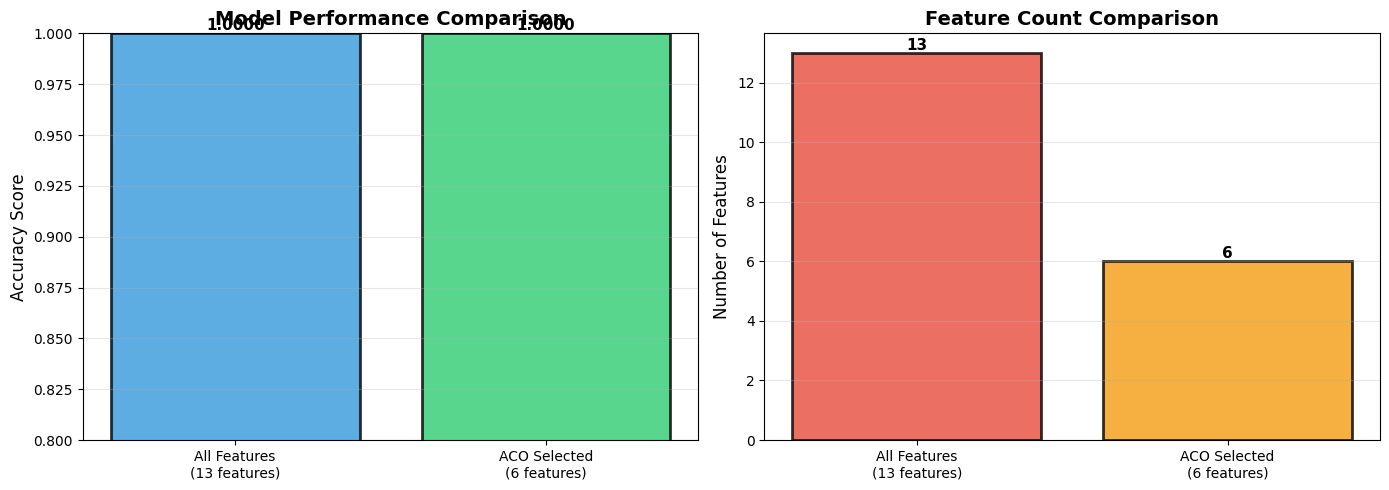

In [7]:
# Block 6: Model Comparison - All Features vs ACO Selected Features
# Model with all features
clf_all = RandomForestClassifier(n_estimators=100, random_state=42)
clf_all.fit(X_train_scaled, y_train)
y_pred_all = clf_all.predict(X_test_scaled)
accuracy_all = accuracy_score(y_test, y_pred_all)

# Model with ACO selected features
X_train_selected = X_train_scaled[:, aco.best_solution]
X_test_selected = X_test_scaled[:, aco.best_solution]
clf_aco = RandomForestClassifier(n_estimators=100, random_state=42)
clf_aco.fit(X_train_selected, y_train)
y_pred_aco = clf_aco.predict(X_test_selected)
accuracy_aco = accuracy_score(y_test, y_pred_aco)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
models = ['All Features\n(13 features)', 'ACO Selected\n(' + str(aco.best_solution.sum()) + ' features)']
accuracies = [accuracy_all, accuracy_aco]
colors_bar = ['#3498db', '#2ecc71']
bars = axes[0].bar(models, accuracies, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Accuracy Score', fontsize=12)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0.8, 1.0])
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Feature comparison
feature_counts = [len(X.columns), aco.best_solution.sum()]
bars2 = axes[1].bar(models, feature_counts, color=['#e74c3c', '#f39c12'], alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Number of Features', fontsize=12)
axes[1].set_title('Feature Count Comparison', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, count in zip(bars2, feature_counts):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()



Provides detailed metrics and insights
- The algorithm uses ants that probabilistically select features based on pheromone levels (learned importance) and heuristic information (RF feature importance). Better feature subsets deposit more pheromones, creating a positive feedback loop that converges to an optimal feature set.

In [8]:
# Block 7: Detailed Performance Metrics
print("\n" + "="*70)
print("DETAILED PERFORMANCE METRICS")
print("="*70)

print("\n📊 Model with ALL Features:")
print(f"   Accuracy: {accuracy_all:.4f}")
print(f"   Features Used: {len(X.columns)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_all, target_names=wine.target_names))

print("\n" + "="*70)
print("\n🐜 Model with ACO SELECTED Features:")
print(f"   Accuracy: {accuracy_aco:.4f}")
print(f"   Features Used: {aco.best_solution.sum()}")
print(f"   Feature Reduction: {(1 - aco.best_solution.sum()/len(X.columns))*100:.1f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_aco, target_names=wine.target_names))

print("\n" + "="*70)
print("💡 INSIGHTS:")
print("="*70)
improvement = accuracy_aco - accuracy_all
if improvement > 0:
    print(f"✅ ACO improved accuracy by {improvement:.4f} using fewer features!")
elif improvement < -0.01:
    print(f"⚠️  ACO reduced accuracy by {abs(improvement):.4f}, but uses {(1-aco.best_solution.sum()/len(X.columns))*100:.1f}% fewer features")
else:
    print(f"✅ ACO maintained similar accuracy ({abs(improvement):.4f} difference) with fewer features!")
print(f"🎯 Computational efficiency improved by reducing features from {len(X.columns)} to {aco.best_solution.sum()}")
print("="*70)


DETAILED PERFORMANCE METRICS

📊 Model with ALL Features:
   Accuracy: 1.0000
   Features Used: 13

Classification Report:
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        18
     class_1       1.00      1.00      1.00        21
     class_2       1.00      1.00      1.00        15

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



🐜 Model with ACO SELECTED Features:
   Accuracy: 1.0000
   Features Used: 6
   Feature Reduction: 53.8%

Classification Report:
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        18
     class_1       1.00      1.00      1.00        21
     class_2       1.00      1.00      1.00        15

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1